In [9]:
import random as rd
import numpy  as np
import math   as mt
import pandas as pd
import os     as os
from collections import OrderedDict
import sys 
import matplotlib.pyplot as plt
import matplotlib as mtb
from matplotlib.ticker import MaxNLocator
from matplotlib import colors as mcolors
import scipy.io
import scipy.stats
from scipy.interpolate import make_interp_spline

import matlab.engine
eng = matlab.engine.start_matlab()
 
import matplotlib.font_manager as font_manager
fnt = font_manager.FontProperties(family='Times', style='normal')
fontface = 'Times'

plt.rcParams.update({'font.family':'Times'})

clrs = dict(mcolors.BASE_COLORS, **mcolors.TABLEAU_COLORS)
del clrs['w']
 
beep = lambda x: os.system("echo -n '\a';sleep 0.5;" * x)

In [26]:
### Trial features
experiment = 2
basetempo = 100    # [beats per minute]
smoolth   = 5      # []

### Cognitive properties of agents A (and B)

# delay offsets [Agent A, Agent B]
landa   = [0.5, 0.5] 
u_I     = [1, 2]   # Auditory delay (StimulusA to ClickA)  [milliseconds]
m_I     = [1, 3]   # Motor Delay (MotorA to ResponseA) [milliseconds]
f_ITactile = [14,14]  # Tactile [feedback] Delay (ResponseA to TactilTapA) [milliseconds]
tau_airborne = [1, 1]   # Airborne Sound Delay (ResponseA to EarA) [milliseconds]
eta = [.8, .8]

# memory
n = [2, 2]         # number of terms in the memory vector (n in the paper)
a = 2               # scaling factor in memory vector [integer]
psi = [[a**(j-i-1)*(a-1) / float(a**j - 1) for i in range(j)] for j in n]

# error correction parameters
alpha = [0.45, 0.35]    # phase correction gain (fixed value between 0.5 and 1 randomly selected from a uniform distribution)  [scalar]
beta  = [0.3, 0.5]     # period correction gain (between 0 and 0.4)  [scalar]

tau_phase  = [10, 10] # Asynchrony tolerance threshold [milliseconds]
tau_period1 = [.07, .1] # Discrepancy tolerance ratio (plus)  [scalar] ## distribution!!!
tau_period2 = [.07, .1] # Discrepancy tolerance ratio (minus) [scalar]
LowerIOI  = [150, 200]   # Human Limits [milliseconds]
UpperIOI  = [2000, 1800] # Human Limits [milliseconds]

markers = ['.', '+', 'x', '*']
colors  = ['blue','red']
agents  = ['A', 'B']

### Change queries based on the experiment  
exps = ['NMA', 'Duet', 'Step']

if experiment == 1: # figure 5
    experiments = ['Agent', 'Metronome'] 
    delays = [0]  # ResponseA to StimulusB   
    tempos = [100]
    tau_jitter  = [[0,8.5], [0,0]] 
    directions = [0]
    numrep = 10
    N = 30
    eta = [0, 0]
    landas = [[x, x] for x in np.arange(0,1.1,.1)]
    if 0: # figure 4
        delays = [0]  
        tempos = [100] 
        N = 50
elif experiment == 2: # figure 8
    experiments = ['Agent', 'Agent'] 
    delays = [1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 78]  # ResponseA to StimulusB   
    tempos = [86, 90, 94]
    tau_jitter  = [[0,8.5], [0,9.3]] 
    landas = [[0.5, 0.5]]
    directions = [0]
    numrep = 30
    N = 20 
    if 1: # figure 6
        delays = [0] 
        tempos = [100]
        N = 50
else: # figure 9
    experiments = ['Agent', 'StepChange']
    delays = [0]
    tempos = [140] 
    landas = [[0.5, 0.5]]
    tau_jitter = [[0,8.5], [0,0]]  
    directions = [+1, -1]
    numrep = 1
    N = 30
    n = [1, 1]
    if 0: # figure 10,11, 12
        tempos = [102, 103, 104, 105, 106, 107, 108, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]

JitterMean = [tau_jitter[0][1], tau_jitter[1][1]]

### Initial nan values for trial variables
# Events
S = [np.zeros(N), np.zeros(N)] # stimulus [milliseconds]
R = [np.zeros(N), np.zeros(N)] # response [milliseconds]

# Constraints
Lower_Discr = [np.full(N, np.nan), np.full(N, np.nan)]
Lower_Async = [np.full(N, np.nan), np.full(N, np.nan)] 
Upper_Discr = [np.full(N, np.nan), np.full(N, np.nan)]
Upper_Async = [np.full(N, np.nan), np.full(N, np.nan)]
# Rules applied
Rule  = [[[] for _ in range(N)], [[] for _ in range(N)]]

Label_Limit = [np.nan, np.nan]
Label_Discr = [np.nan, np.nan]
Label_Async = [np.nan, np.nan]

for j in [0, 1]:            
    Label_Limit[j] = 'Rate Limits: ' + str(LowerIOI[j])     + '<$r_{'+str(agents[j])+'}$(k)<'        +str(UpperIOI[j])
    Label_Discr[j] = 'Discrepancy tolerance ratio (' + agents[j] + '):' + str(round(-100*tau_period2[j], 0)) + '%<$d_{k,'+str(agents[j])+'}$'+ '<' +str(round(100*tau_period1 [j],0))+'%'
    Label_Async[j] = 'Asynchrony tolerance threshold (' + agents[j] + '):' + str(-tau_phase[j]) + 'ms <$e_{k,'+str(agents[j])+'}$'+ '<' +str(tau_phase[j])+'ms'

# folders
chartfolder  = '/Users/nimadarabi/Desktop/Result/'
datafolder = "./Data2/"
if not os.path.exists(chartfolder): os.makedirs(folder) 


In [27]:
## simulation
Chafe   = {}
LeadLag = {}
MA      = {}

for ld in range(len(landas)):
    for direction in directions:
        for trial in range(numrep):
            for dl in delays:
                for tempo in tempos:
                    if direction == +1:  # positive, increase IOI, decrease tempo
                        tempo_ratio = basetempo/tempo
                        tm = tempo
                    elif direction == 0: # chafe
                        tm = tempo
                    else:        # negative, decrease IOI, increase tempo
                        tempo_ratio = tempo/basetempo
                        tm = basetempo
                    StartTempo = [tm, tm]
                    delay      = [dl, dl]

                    ### Simulation
                    Rule = [[[] for _ in range(N-1)], [[] for _ in range(N-1)]]
                    r =    [[[] for _ in range(N-1)], [[] for _ in range(N-1)]]
                    s =    [[[] for _ in range(N-1)], [[] for _ in range(N-1)]]
                    for j in [0, 1]:
                        tau_jitter[j][0] = 0
                        R[j][0] = tau_jitter[j][0]
                        Rule[j][0].append(0)
                        r[j][0].append(60000/StartTempo[j])
                    writestr = ''
                    # Cross Assignment
                    for j in [0, 1]:
                        if experiments[j] == 'Agent':
                            S[j][0] = R[np.mod(j+1,2)][0] + delay[np.mod(j+1,2)] #SA[i]
                            s[j][0] = r[np.mod(j+1,2)][0] # set planned/predicted as actual
                    # Calculating the rest of indices
                    for i in range(1, N-1): # Iterate over the trial taps
                        for j in [0, 1]:    # Iterate over the agents A and B
                            if experiments[j] == 'Metronome':
                                Rule[j][i].append(0)
                                r[j][i].append(60000/StartTempo[j])         
                            elif experiments[j] == 'StepChange':
                                if i < n/2:
                                    Rule[j][i].append(0)
                                    r[j][i].append(60000/StartTempo[j])                       
                                else:                       
                                    Rule[j][i].append(0) # 1 !!!
                                    r[j][i].append(60000/(StartTempo[j]*tempo_ratio))     
                            elif experiments[j] == 'Agent': # We already know: R, S, IRI, ISI[j][i-1]                                   
                                if i > n[j]: 
                                    lastIRIs = [r[j][kk][-1] for kk in range(i - n[j],i)]
                                    IRI = np.inner(psi[j], lastIRIs)
                                    lastISIs = [s[j][kk][-1] for kk in range(i - n[j],i)]
                                    ISI = np.inner(psi[j], lastISIs)
                                else:
                                    IRI = r[j][i-1][-1]  # planned default IRI (based on last IRI)
                                    ISI = s[j][i-1][-1]  # anticipated/predicted (based on last ISI)

                                Rule[j][i].append(0)
                                s[j][i].append(ISI)
                                r[j][i].append(IRI)
                                #eta[j] = rd.random()
                                plannedIRI = eta[j]*ISI + (1-eta[j])*IRI # central interval

                                # phase error correction
                                e = R[j][i-1] - S[j][i-1] # asynchrony - phase error - synchronization error
                                landa = landas[ld]
                                f_I = [(u_I[j]+tau_airborne[j])*landa[j]+(1-landa[j])*f_ITactile[j] for j in [0,1]]
                                e_I = e + f_I[j] - u_I[j] # internal asynchrony  - formula (16)
                                phase_correction = 0
                                Lower_Async[j][i] = e_I + plannedIRI - tau_phase[j]       
                                Upper_Async[j][i] = e_I + plannedIRI + tau_phase[j]                          

                                #if (IRI < Lower_Async[j][i]) | (IRI > Upper_Async[j][i]):                            
                                if (e_I < -tau_phase[j]) | (e_I > tau_phase[j]):
                                    phase_correction = -alpha[j]*e_I # formula (17)
                                    Rule[j][i].append(1)

                                # period error correction
                                d = IRI/ISI-1 # period error - discrepancy - formula (18)
                                period_correction = 0
                                if (d > tau_period2[j]) | (d < -tau_period1[j]):
                                    period_correction = -beta[j]*d*ISI  # formula (19)
                                    Rule[j][i].append(2)
                                Lower_Discr[j][i] = (1-tau_period2[j])*ISI
                                Upper_Discr[j][i] = (1+tau_period1[j])*ISI  
                                #print (i, '-> ISI:', ISI, ', IRI:', IRI, 'period:', period_correction, ', phase:', phase_correction)

                                correction_term = phase_correction + period_correction # formula (20)
                                
                                # Testing ADAM
                                adaptation = correction_term
                                
                                #anticipation = 
                                
                                IRI = plannedIRI + correction_term # formula (15) - some parts
                                # lower/upper limits
                                if IRI < LowerIOI[j]: IRI = LowerIOI[j] # section 2.11
                                if IRI > UpperIOI[j]: IRI = UpperIOI[j] # section 2.11
                                r[j][i].append(IRI)                                

                            # Up till here for all types of experiments the next (Rule[j][i], IRI[j][i]) is decided                      
                            jitter_mean = tau_jitter[j][0]
                            jitter_std  = tau_jitter[j][1]                        
                            xi = np.random.normal (jitter_mean, jitter_std) # Temporal perturbation taken from a Gaussian distribution (Elliott, Wing et al. 2010) with a std of 5 to 20 ms and a mean of zero !!!
                            R[j][i] = R[j][i-1] + r[j][i][-1] + xi  # formula (15) - other parts

                            newstr = "<timestep>"+str(i)+', '+['U', 'M'][j]+' '+str(int(R[j][i]))+'</timestep>'+'\n' #<timestep>1, M 0</timestep>
                            writestr = writestr + newstr
                        for j in [0, 1]:
                            S[j][i] = R[np.mod(j+1,2)][i] + delay[np.mod(j+1,2)] 
                            s[j][i].append(S[j][i] - S[j][i-1])                  

                    a = [tt[-1] for tt in r[0]]
                    b = [tt[-1] for tt in r[1]]
                    Chafe[dl, tempo, trial] = [60000/(tt+ll)*2 for tt,ll in zip(a,b)]
                    z = 1
                    LeadLag [dl, tempo, trial] = -(R[0][:-z]-R[1][:-z] +  R[1][z:]-R[1][z:])[1:]
                    MA [ld, dl, trial] = R[0]-R[1]

                    if experiment == 3:
                        folder = datafolder+str(experiments[0])+',a='+str(alpha[0])+',b='+str(beta[0])+',m='+str(n_[0])+'/'
                        if not os.path.exists(folder): os.makedirs(folder)
                        filename = folder + str(round([tm*tempo_ratio, tm][int((direction+1)/2)]))+'-'+str(trial+1)+['-positive','-negative'][int((direction+1)/2)]+'.XML'
                        with open(filename, 'w') as f:
                            f.write(writestr)
                            if trial == numrep -1 :
                                print (filename+' was written.')

for j in [0, 1]: Rule[j] = Rule[j][1:] + [Rule[j][0]]
beep(1)


0

<IPython.core.display.Javascript object>


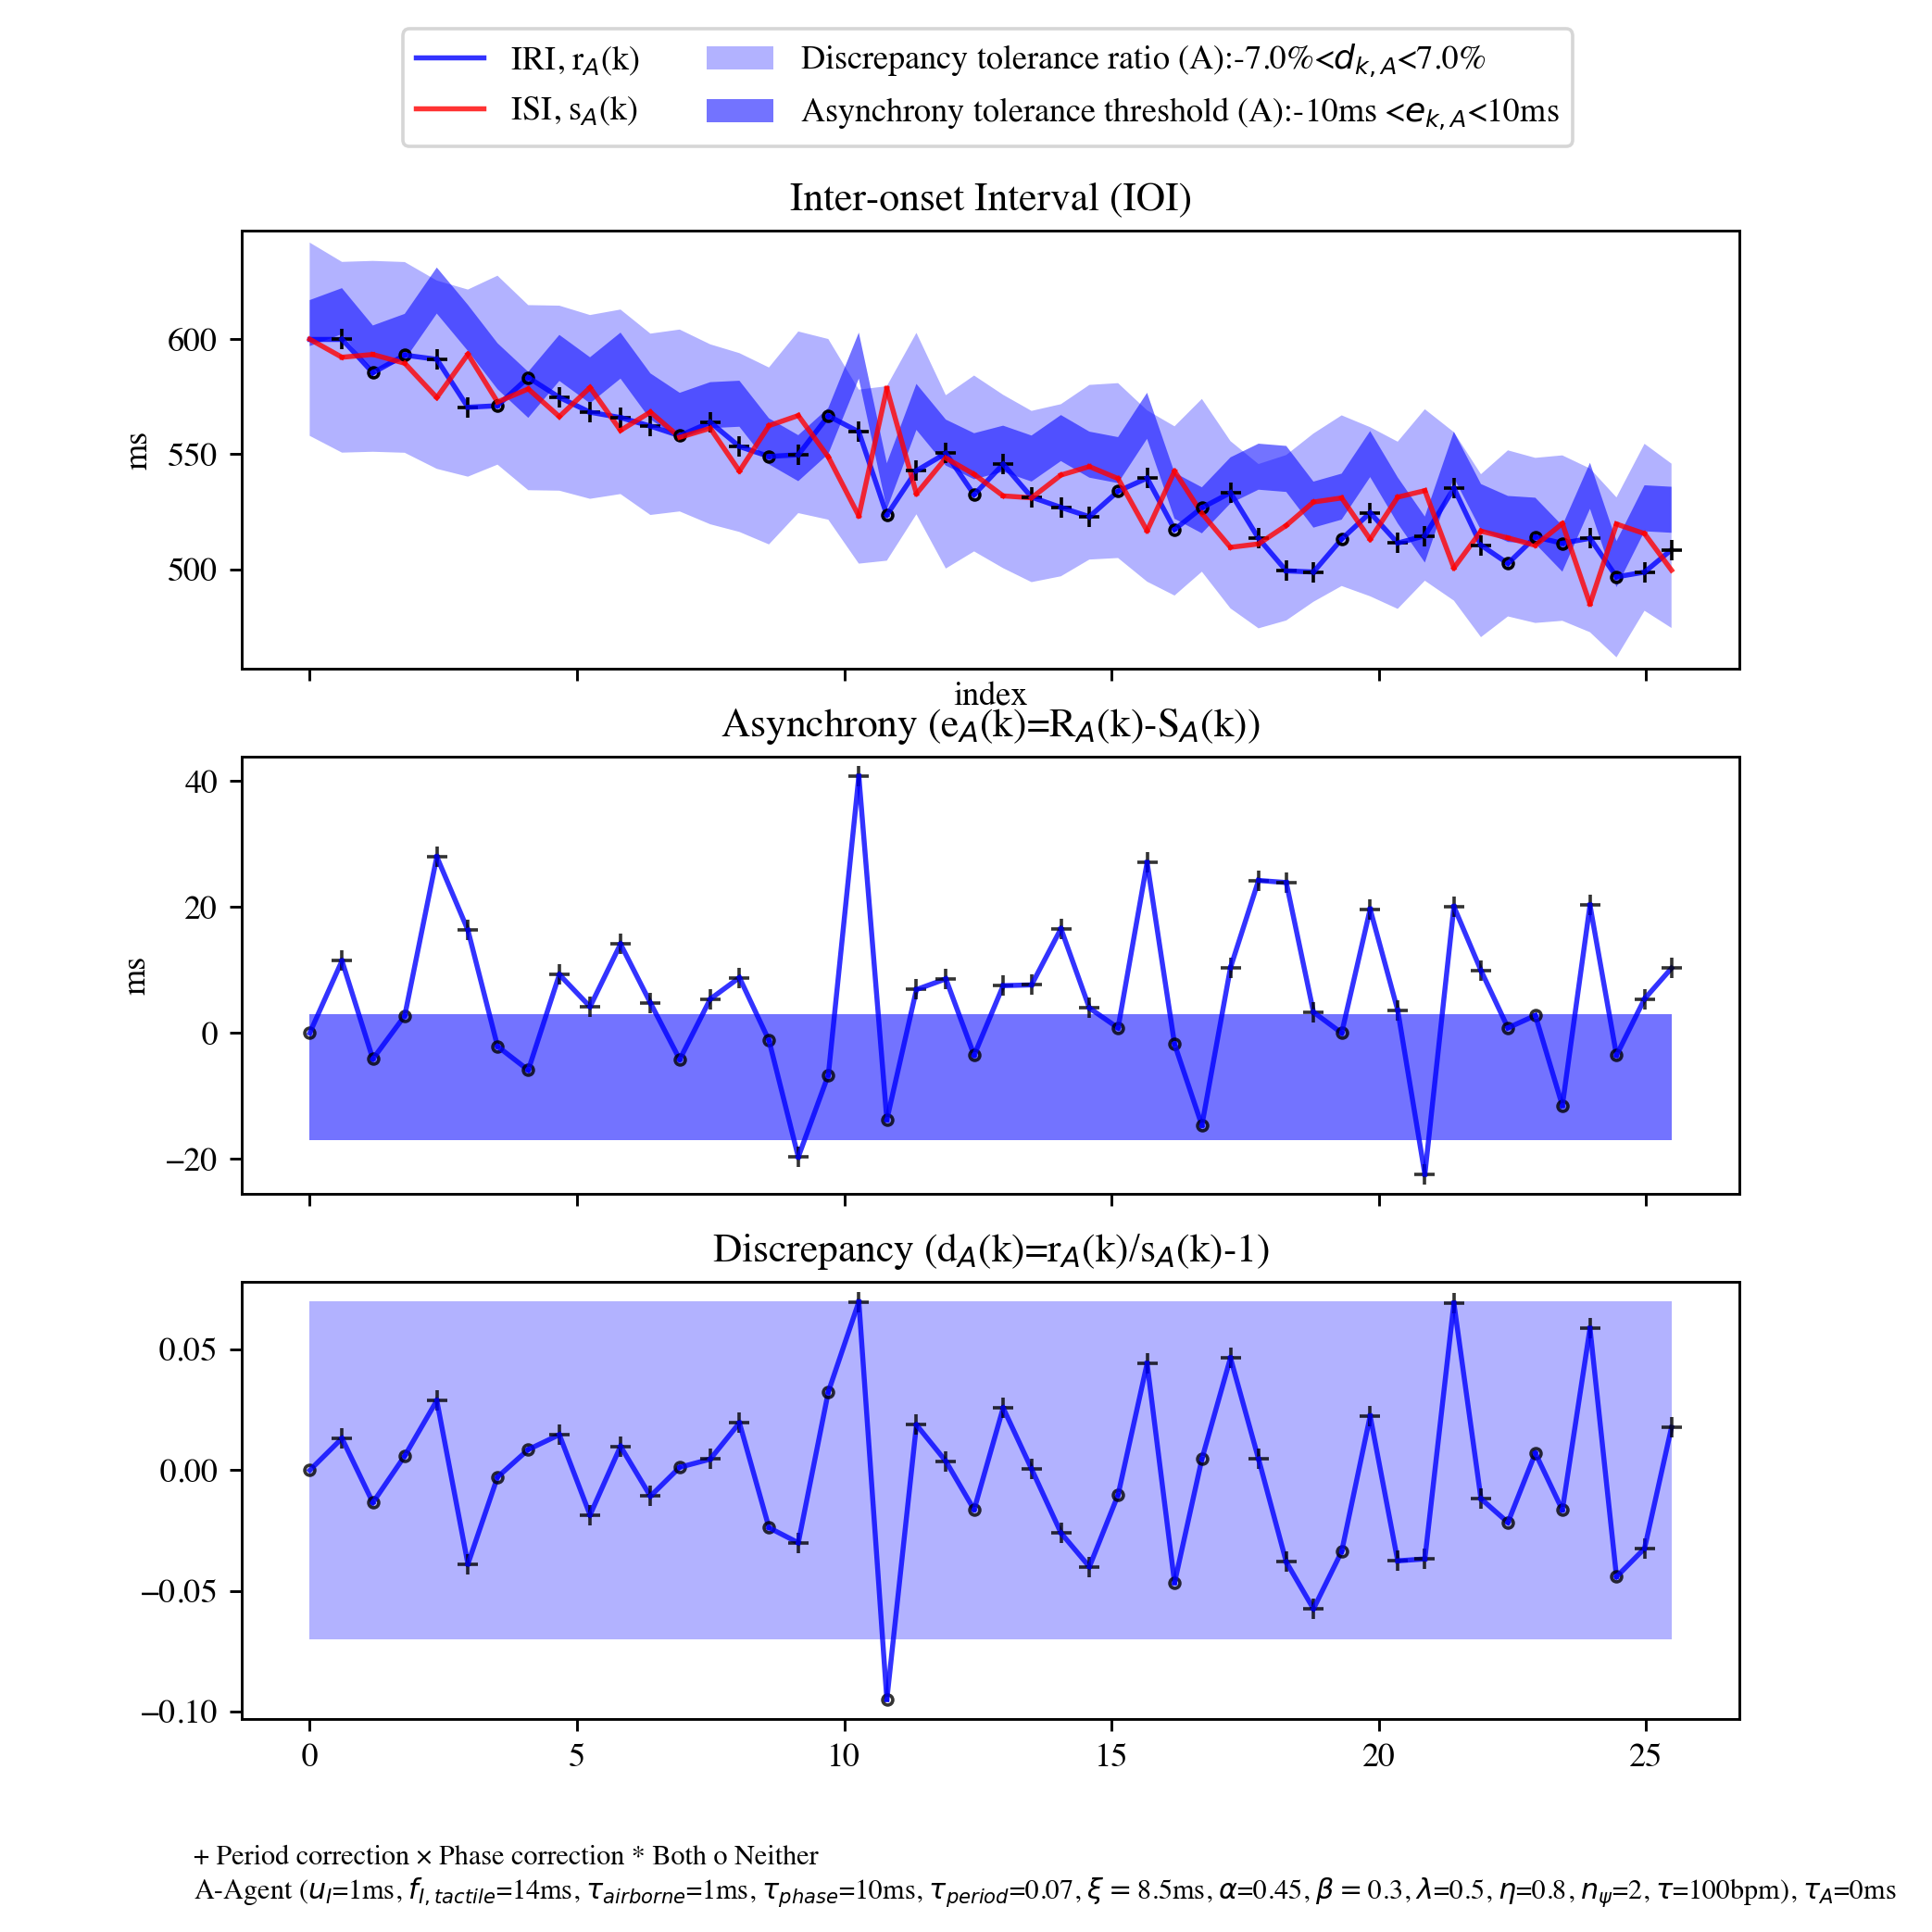

/Users/nimadarabi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Unrecognized location 'top center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


<IPython.core.display.Javascript object>


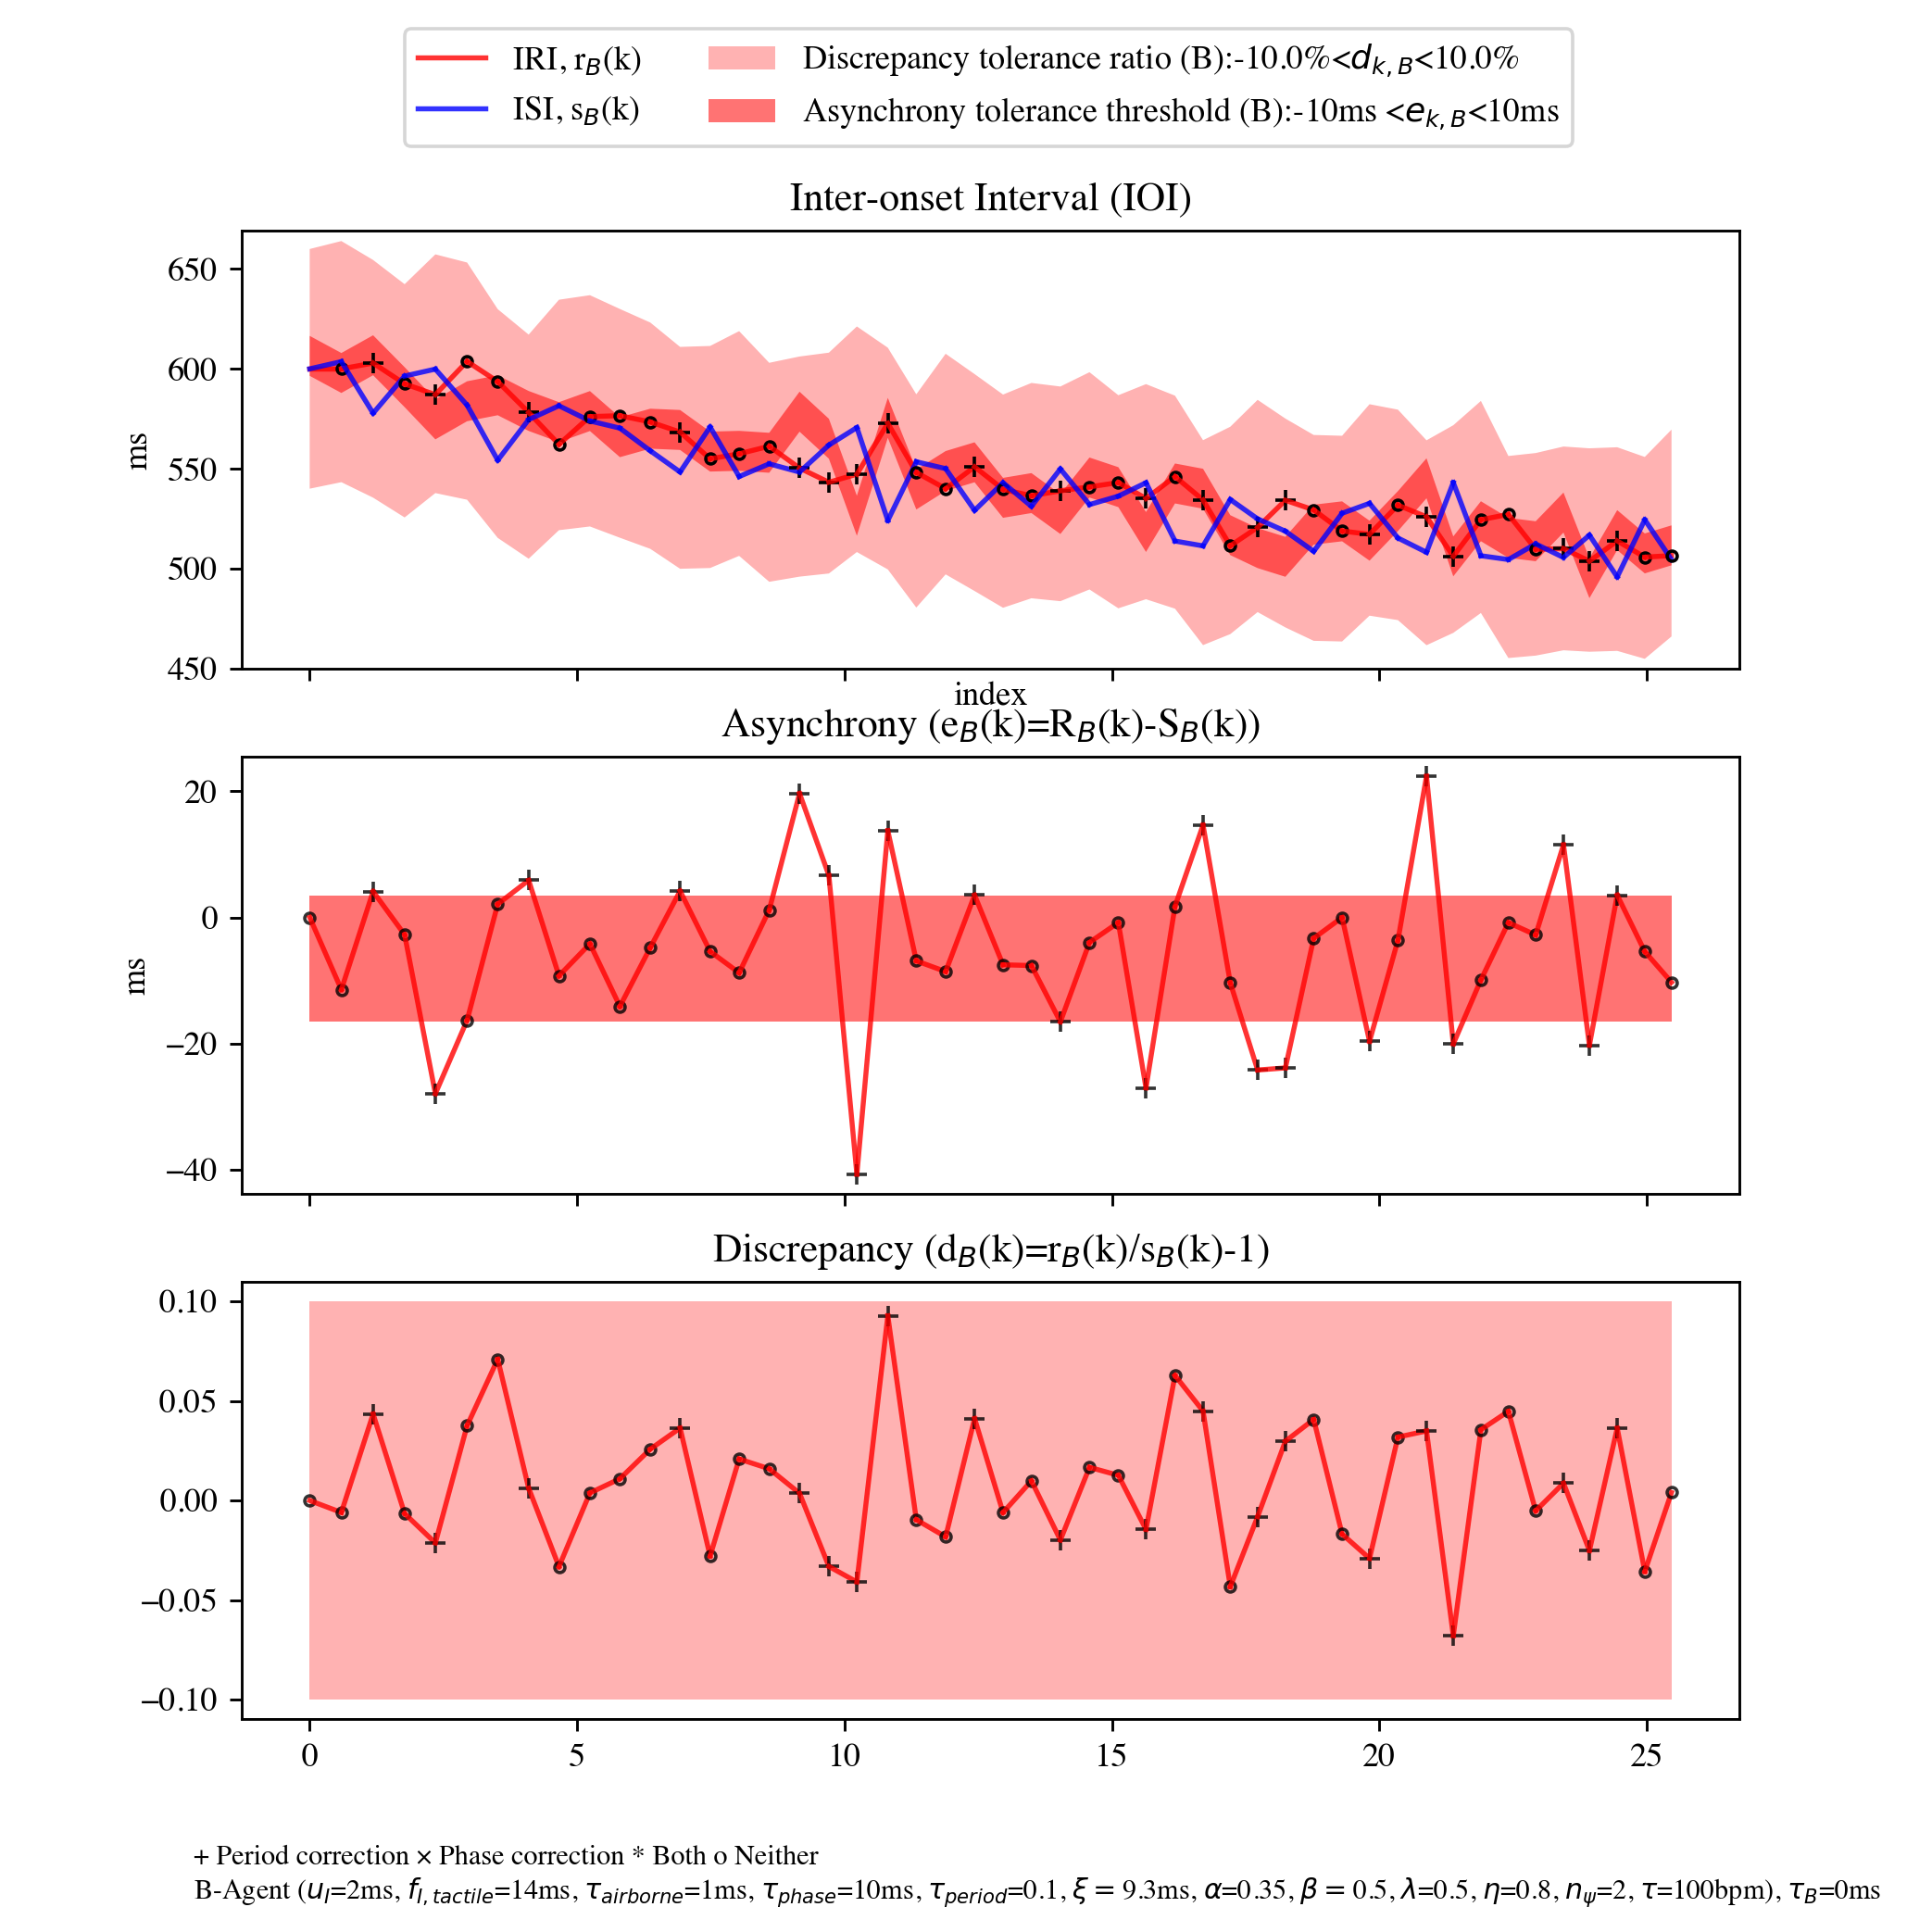

In [28]:
## Analysis
%matplotlib nbagg

thislabel = []
for j in [0, 1]: # A and B
    if experiments[j] == 'Agent':
        thislabel = str(agents[j])  + '-' + str(experiments[j])  + \
            ' ($u_I$='             + str(u_I[j])    + 'ms' +\
            ', $f_{I,tactile}$='   + str(f_ITactile[j])    + 'ms' +\
            ', $\\tau_{airborne}$=' + str(tau_airborne[j])    + 'ms' +\
            ', $\\tau_{phase}$='    + str(tau_phase[j])   + 'ms' +\
            ', $\\tau_{period}$='   + str(tau_period1[j])  +\
            ', $\\xi=$'             + str(JitterMean[j]) + 'ms' +\
            ', $\\alpha$='          + str(alpha[j])      + '' +\
            ', $\\beta=$'           + str(beta[j])       + '' +\
            ', $\lambda$='          + str(landa[j])      + '' +\
            ', $\eta$='             + str(eta[j])      + '' +\
            ', $n_\psi$='           + str(n[j])     + '' +\
            ', $\\tau$='            + str(StartTempo[j]) + 'bpm)'+\
            ', $\\tau_'+str(agents[j])+'$=' + str(delay[j]) + 'ms\n'
    elif experiments[j] == 'Metronome':
        thislabel = str(agents[j]) + '-' + str(experiments[j])  + \
            ' ($\\tau$='    + str(StartTempo[j]) + 'bpm)'
    else:
        thislabel = str(agents[j]) + '-' + str(experiments[j])  + \
            ' ($\\tau$='    + str(StartTempo[j]) + 'bpm)'
        
    c1 = colors[j]
    c2 = colors[np.mod(j+1,2)] 
    markerz = '+ Period correction × Phase correction * Both o Neither\n'

    if 0:
        x = range(n)[:-1]
        xlabel = 'Clap Index'
    else:
        x = R[j][:-1]/1000
        xlabel = 'Time (s)'
    # Iterate over all notes to plot metrics

    if experiments[j] == 'Agent':
        f, axarr = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
        f.suptitle("" , fontweight='bold')
        minn = np.nanmin(np.concatenate((Lower_Async[j], Lower_Discr[j], [iri[-1] for iri in r[j]])))-5
        maxx = np.nanmax(np.concatenate((Upper_Async[j], Upper_Discr[j], [iri[-1] for iri in r[j]])))+5
        axarr[0].set_ylim ([minn,maxx])
        axarr[0].fill_between(x[:-1], Lower_Discr[j][1:-1], Upper_Discr[j][1:-1], where=1, facecolor=c1, interpolate=True, alpha=0.3, label=Label_Discr[j], )                  
        axarr[0].fill_between(x[:-1], Lower_Async[j][1:-1], Upper_Async[j][1:-1], where=1, facecolor=c1, interpolate=True, alpha=0.55, label=Label_Async[j], )            
        #axarr[0].plot(x[:-1], LowerIOI[j], c=c1, linewidth=1, linestyle=':', label=Label_Limit) 
        #axarr[0].plot(x[:-1], UpperIOI[j], c=c1, linewidth=1, linestyle=':', label=Label_Limit)  

        axarr[1].fill_between(x[:-1], -tau_phase[j] - (f_I[j] - u_I[j]), \
                              tau_phase[j] - (f_I[j] - u_I[j]), where=1, \
                              facecolor=c1, interpolate=True, alpha=0.55)                  
        axarr[2].fill_between(x[:-1], -tau_period2[j], tau_period1[j], where=1, \
                              facecolor=c1, interpolate=True, alpha=0.3)  

        for k, xx, resp, stim, iri, isi, rule in zip(range(len(Rule[j])-1),\
                                            x[:-1],\
                                            R[j][:-2],\
                                            S[j][:-2],\
                                            r[j][:-1],\
                                            s[j][:-1],\
                                            Rule[j][:-1]):

            asynch = resp - stim                # External Asynchrony
            if len(isi) == 0 : print ('error: ISI was empty!'), isi.append(0)
            discrp = np.divide(iri[-1], isi[-1])-1 # Discrepancy

            lbl1 = 'IRI, r$_{'+ agents[j] +'}$(k)' if k == 1 else '' # add markerz instead of text
            lbl2 = 'ISI, s$_{'+ agents[j] +'}$(k)' if k == 1 else ''
            if k > 0:
                axarr[0].plot([xx_, xx], [iri_[-1], iri[-1]], color=c1, alpha=0.8, label=lbl1) 
                axarr[0].plot([xx_, xx], [isi_[-1], isi[-1]], color=c2, alpha=0.8, label=lbl2)
                axarr[0].plot(xx, iri[-1], marker=markers[sum(rule)], color='black', mfc='none', alpha=1)

            axarr[0].set_title('Inter-onset Interval (IOI)', fontname=fontface)
            axarr[0].set_ylabel('ms', fontname=fontface)
            axarr[0].set_xlabel('index', fontname=fontface)
            if experiments[j] == 'Agent':
                if k > 0: axarr[1].plot([xx_, xx], [asynch_, asynch], color=c1, alpha=0.8)                                     
                axarr[1].plot(xx, asynch, marker=markers[sum(rule)], color='black', mfc='none', alpha=0.8)     
                axarr[1].set_title('Asynchrony (e$_{'+ agents[j] +'}$(k)=R$_{'+ agents[j] +'}$(k)-S$_{'+ agents[j] +'}$(k))', fontname=fontface) 
                axarr[1].set_ylabel('ms', fontname=fontface)
                if k > 0: axarr[2].plot([xx_, xx], [discrp_, discrp], color=c1, alpha=0.8)
                axarr[2].plot(xx, discrp, marker=markers[sum(rule)], color='black', mfc='none', alpha=0.8)
                axarr[2].set_title('Discrepancy (d$_{'+ agents[j] +'}$(k)=r$_{'+ agents[j] +'}$(k)/s$_{'+ agents[j] +'}$(k)-1)', fontname=fontface)
                axarr[2].set_ylabel('', fontname=fontface)

            xx_ = xx
            iri_ = iri
            isi_ = isi
            asynch_ = asynch
            discrp_ = discrp
        axarr[0].legend(loc="top center", title='', fontsize = 'x-small', ncol=2, prop=fnt, bbox_to_anchor=(.9, 1.5)) # title='-'.join(experiments)

        plt.figtext(0.1, -0.0, markerz+''.join(thislabel)  , size='small', fontname=fontface)

        f.savefig(chartfolder+'/'+ exps[experiment-1] +'-' + str(agents[j])+'.jpg', dpi=300)
        

## Results

In [24]:
#Mean Asynchrony - Figure 5
%matplotlib nbagg
dc = {}
if experiment == 1:
    q = int(mt.ceil(mt.sqrt(len(delays))))
    f4, ax4 = plt.subplots(figsize=(8, 8), sharex=False)  
    f4.suptitle("" , fontweight='bold')
    ax4.axhline(y=0, linestyle=':', color='k', alpha=0.4)

    j = 0
    for ld in range(len(landas)):
        for t in range(len(tempos)):
            ax4.axvline(x=landas[ld][j], linestyle=':', color='k', alpha=0.4)
            stt = []

            for i in range(len(delays)):
                dl = delays[i]
                for trial in range(numrep):
                    y = MA[ld, dl, trial][2:]
                    if 1: 
                        ax4.plot(landas[ld][j]+ np.random.randn(1)*0.01, np.mean(y), marker='.', color =['r','g','b'][t], alpha=.3)   
                    stt.append(np.mean(y))        
            m, se = np.mean(stt), scipy.stats.sem(stt)
            h = se * scipy.stats.t.ppf((1 + .95) / 2., len(stt)-1)

            ax4.errorbar(landas[ld][j], np.mean(stt), yerr=h, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

            ax4.set_title('95% confidence interval for mean asynchrony', fontname=fontface) 
            ax4.set_xlabel('$\lambda$ (-)', fontname=fontface)
            ax4.set_ylabel('Mean Asynchrony [$\mu_e$, $e_{A}$(k)=$r_{A}$(k)-$s_{A}$(k), 1≥n≥'+str(n)+'] (ms)', fontname=fontface)
        
    f4.savefig(chartfolder+'/'+ exps[experiment-1] +'-' + str(agents[j])+'-NMA(Figure 5).jpg', dpi=300)

<IPython.core.display.Javascript object>


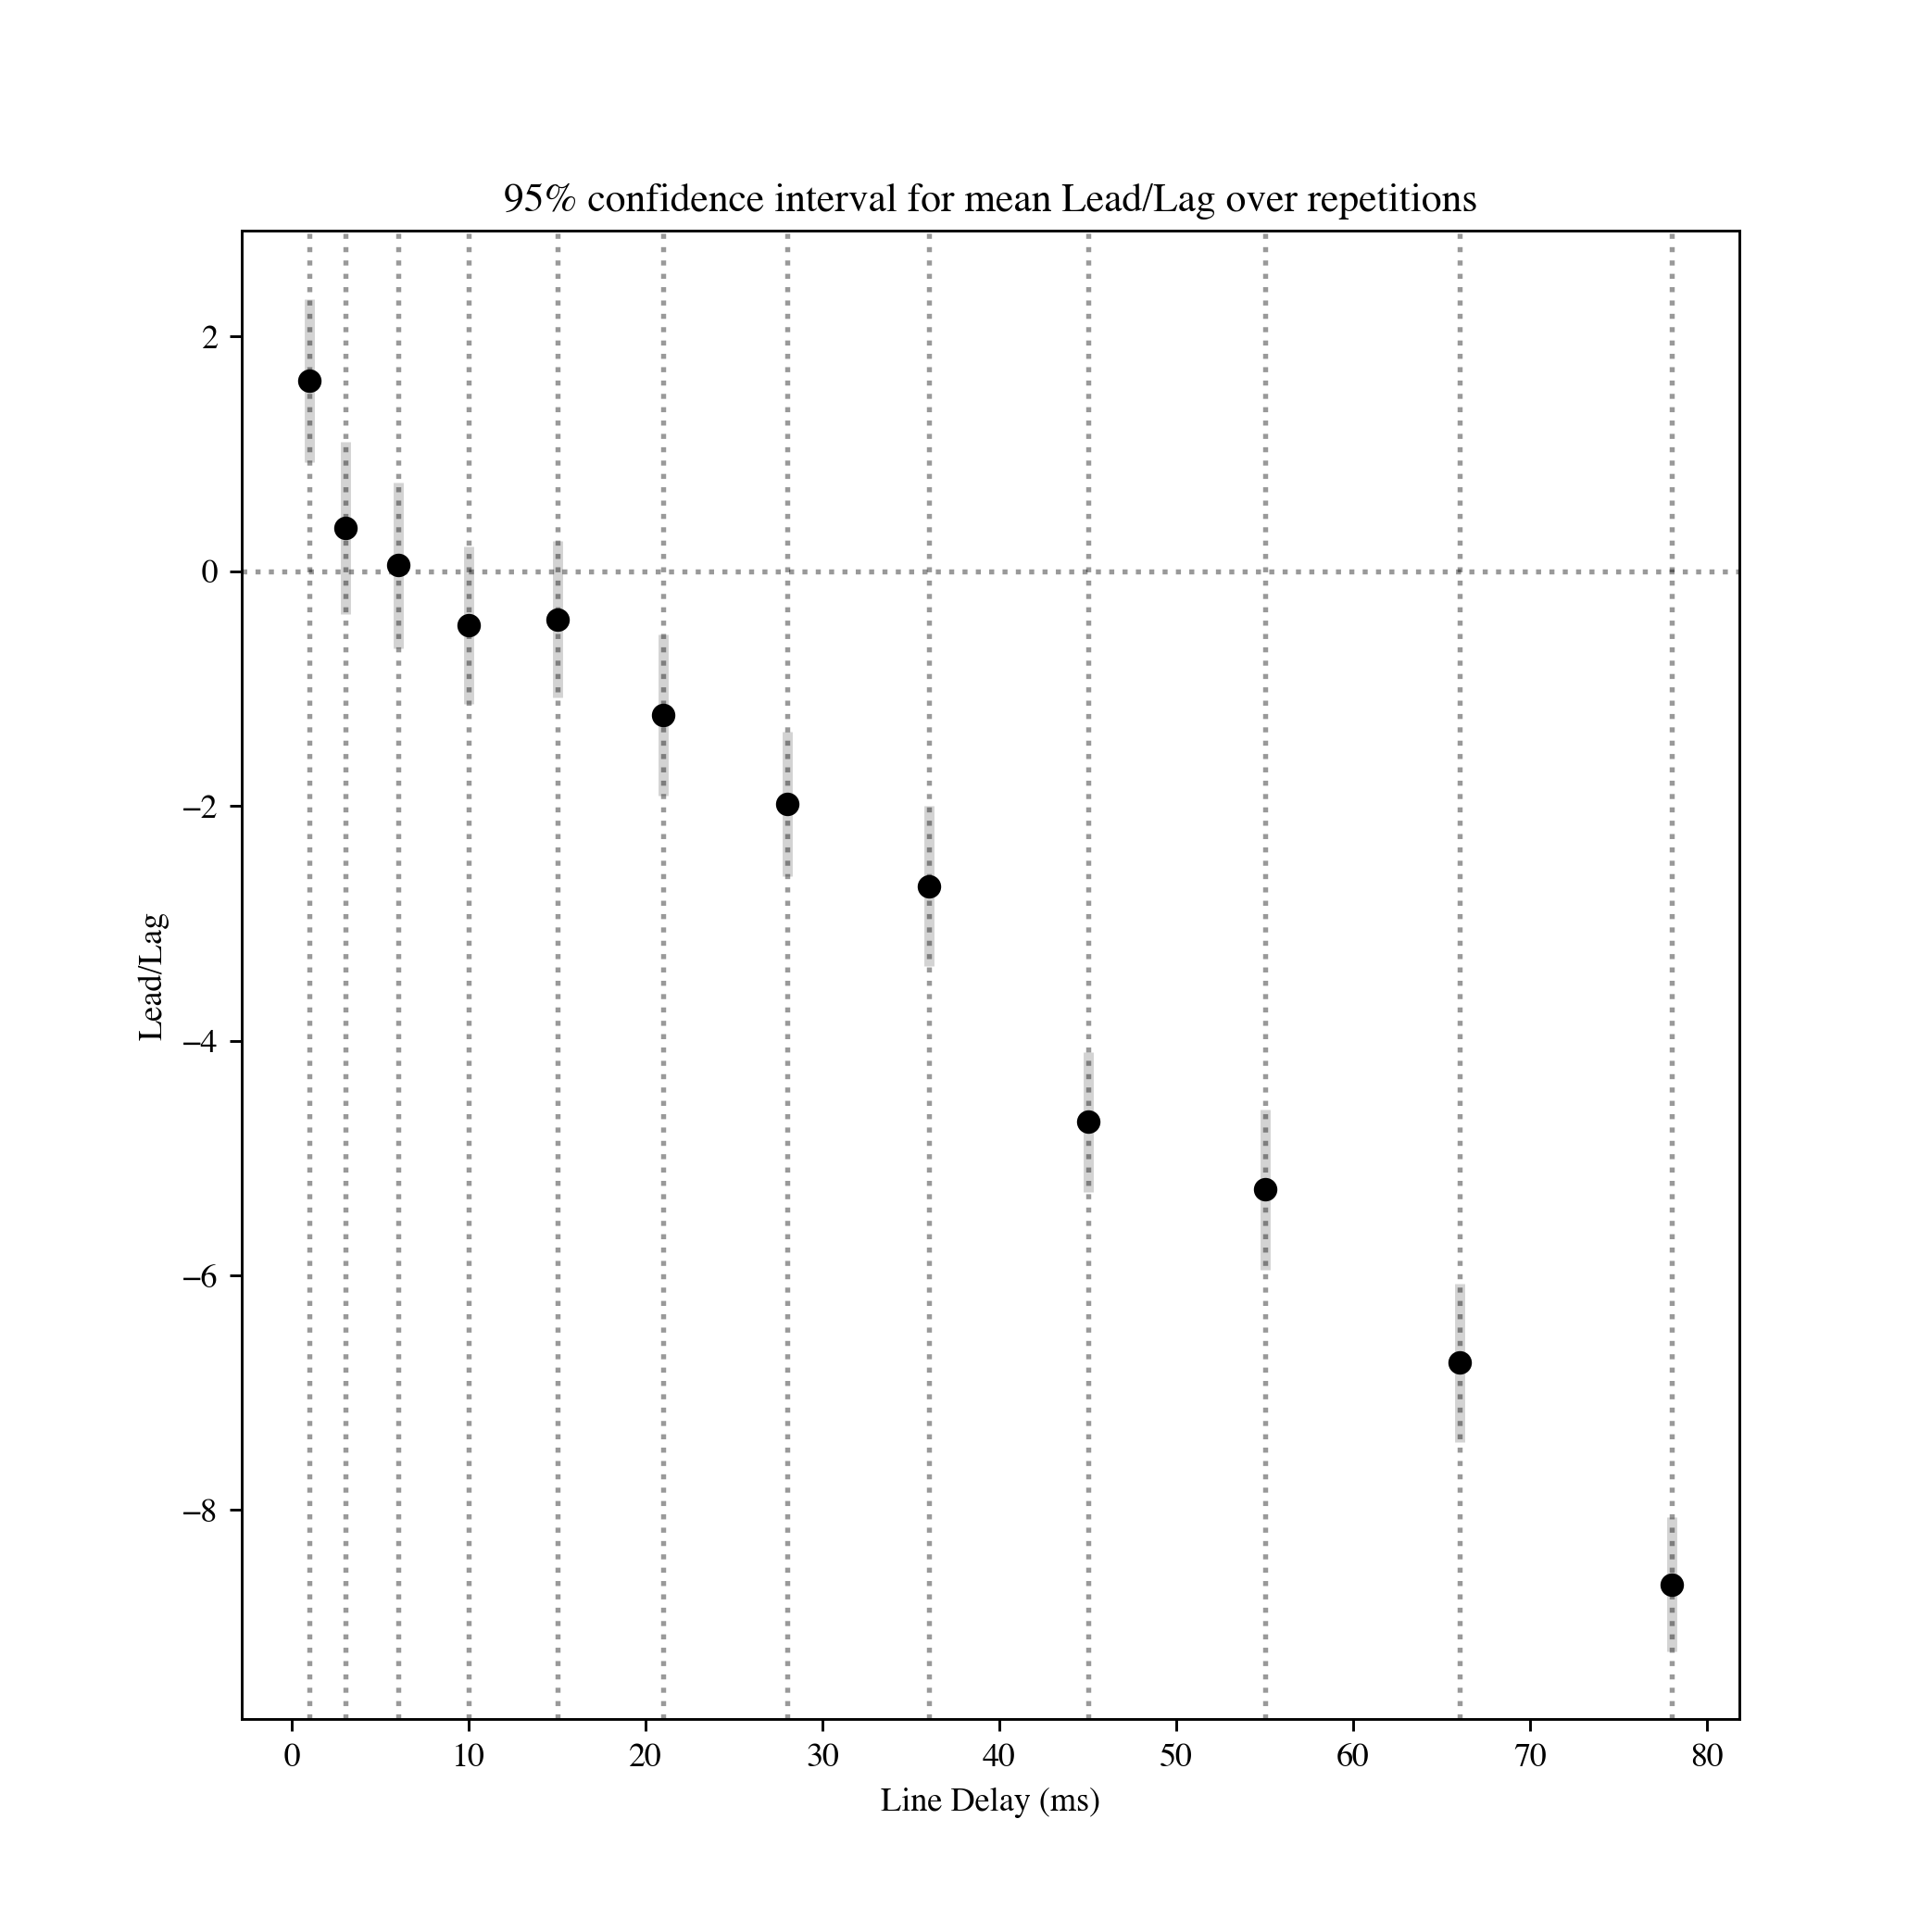

In [19]:
#Lead/Lag Analysis - Figure 8
%matplotlib nbagg
dc = {}
if experiment == 2:
    q = int(mt.ceil(mt.sqrt(len(delays))))
    f3, ax3 = plt.subplots(figsize=(8, 8), sharex=False)  
    f3.suptitle("" , fontweight='bold')
    ax3.axhline(y=0, linestyle=':', color='k', alpha=0.4)

    j = 0
    for i in range(len(delays)):
        dl = delays[i]
        ax3.axvline(x=dl, linestyle=':', color='k', alpha=0.4)
        stt = []
        for t in range(len(tempos)):
            for trial in range(numrep):
                y = LeadLag[(dl,tempos[t], trial)][2:]
                if 0: 
                    ax3.plot(dl+ np.random.randn(1)*0.3, np.mean(y), marker='.', color =['r','g','b'][t], alpha=.3)   
                stt.append(np.mean(y))        
        m, se = np.mean(stt), scipy.stats.sem(stt)
        h = se * scipy.stats.t.ppf((1 + .95) / 2., len(stt)-1)
        
        ax3.errorbar(dl, np.mean(stt), yerr=h, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
        
        ax3.set_title('95% confidence interval for mean Lead/Lag over repetitions', fontname=fontface) 
        ax3.set_xlabel('Line Delay (ms)', fontname=fontface)
        ax3.set_ylabel('Lead/Lag', fontname=fontface)

        
    f3.savefig(chartfolder+'/'+ exps[experiment-1] +'-' + str(agents[j])+'-LeadLag(Figure 8).jpg', dpi=300)

<IPython.core.display.Javascript object>


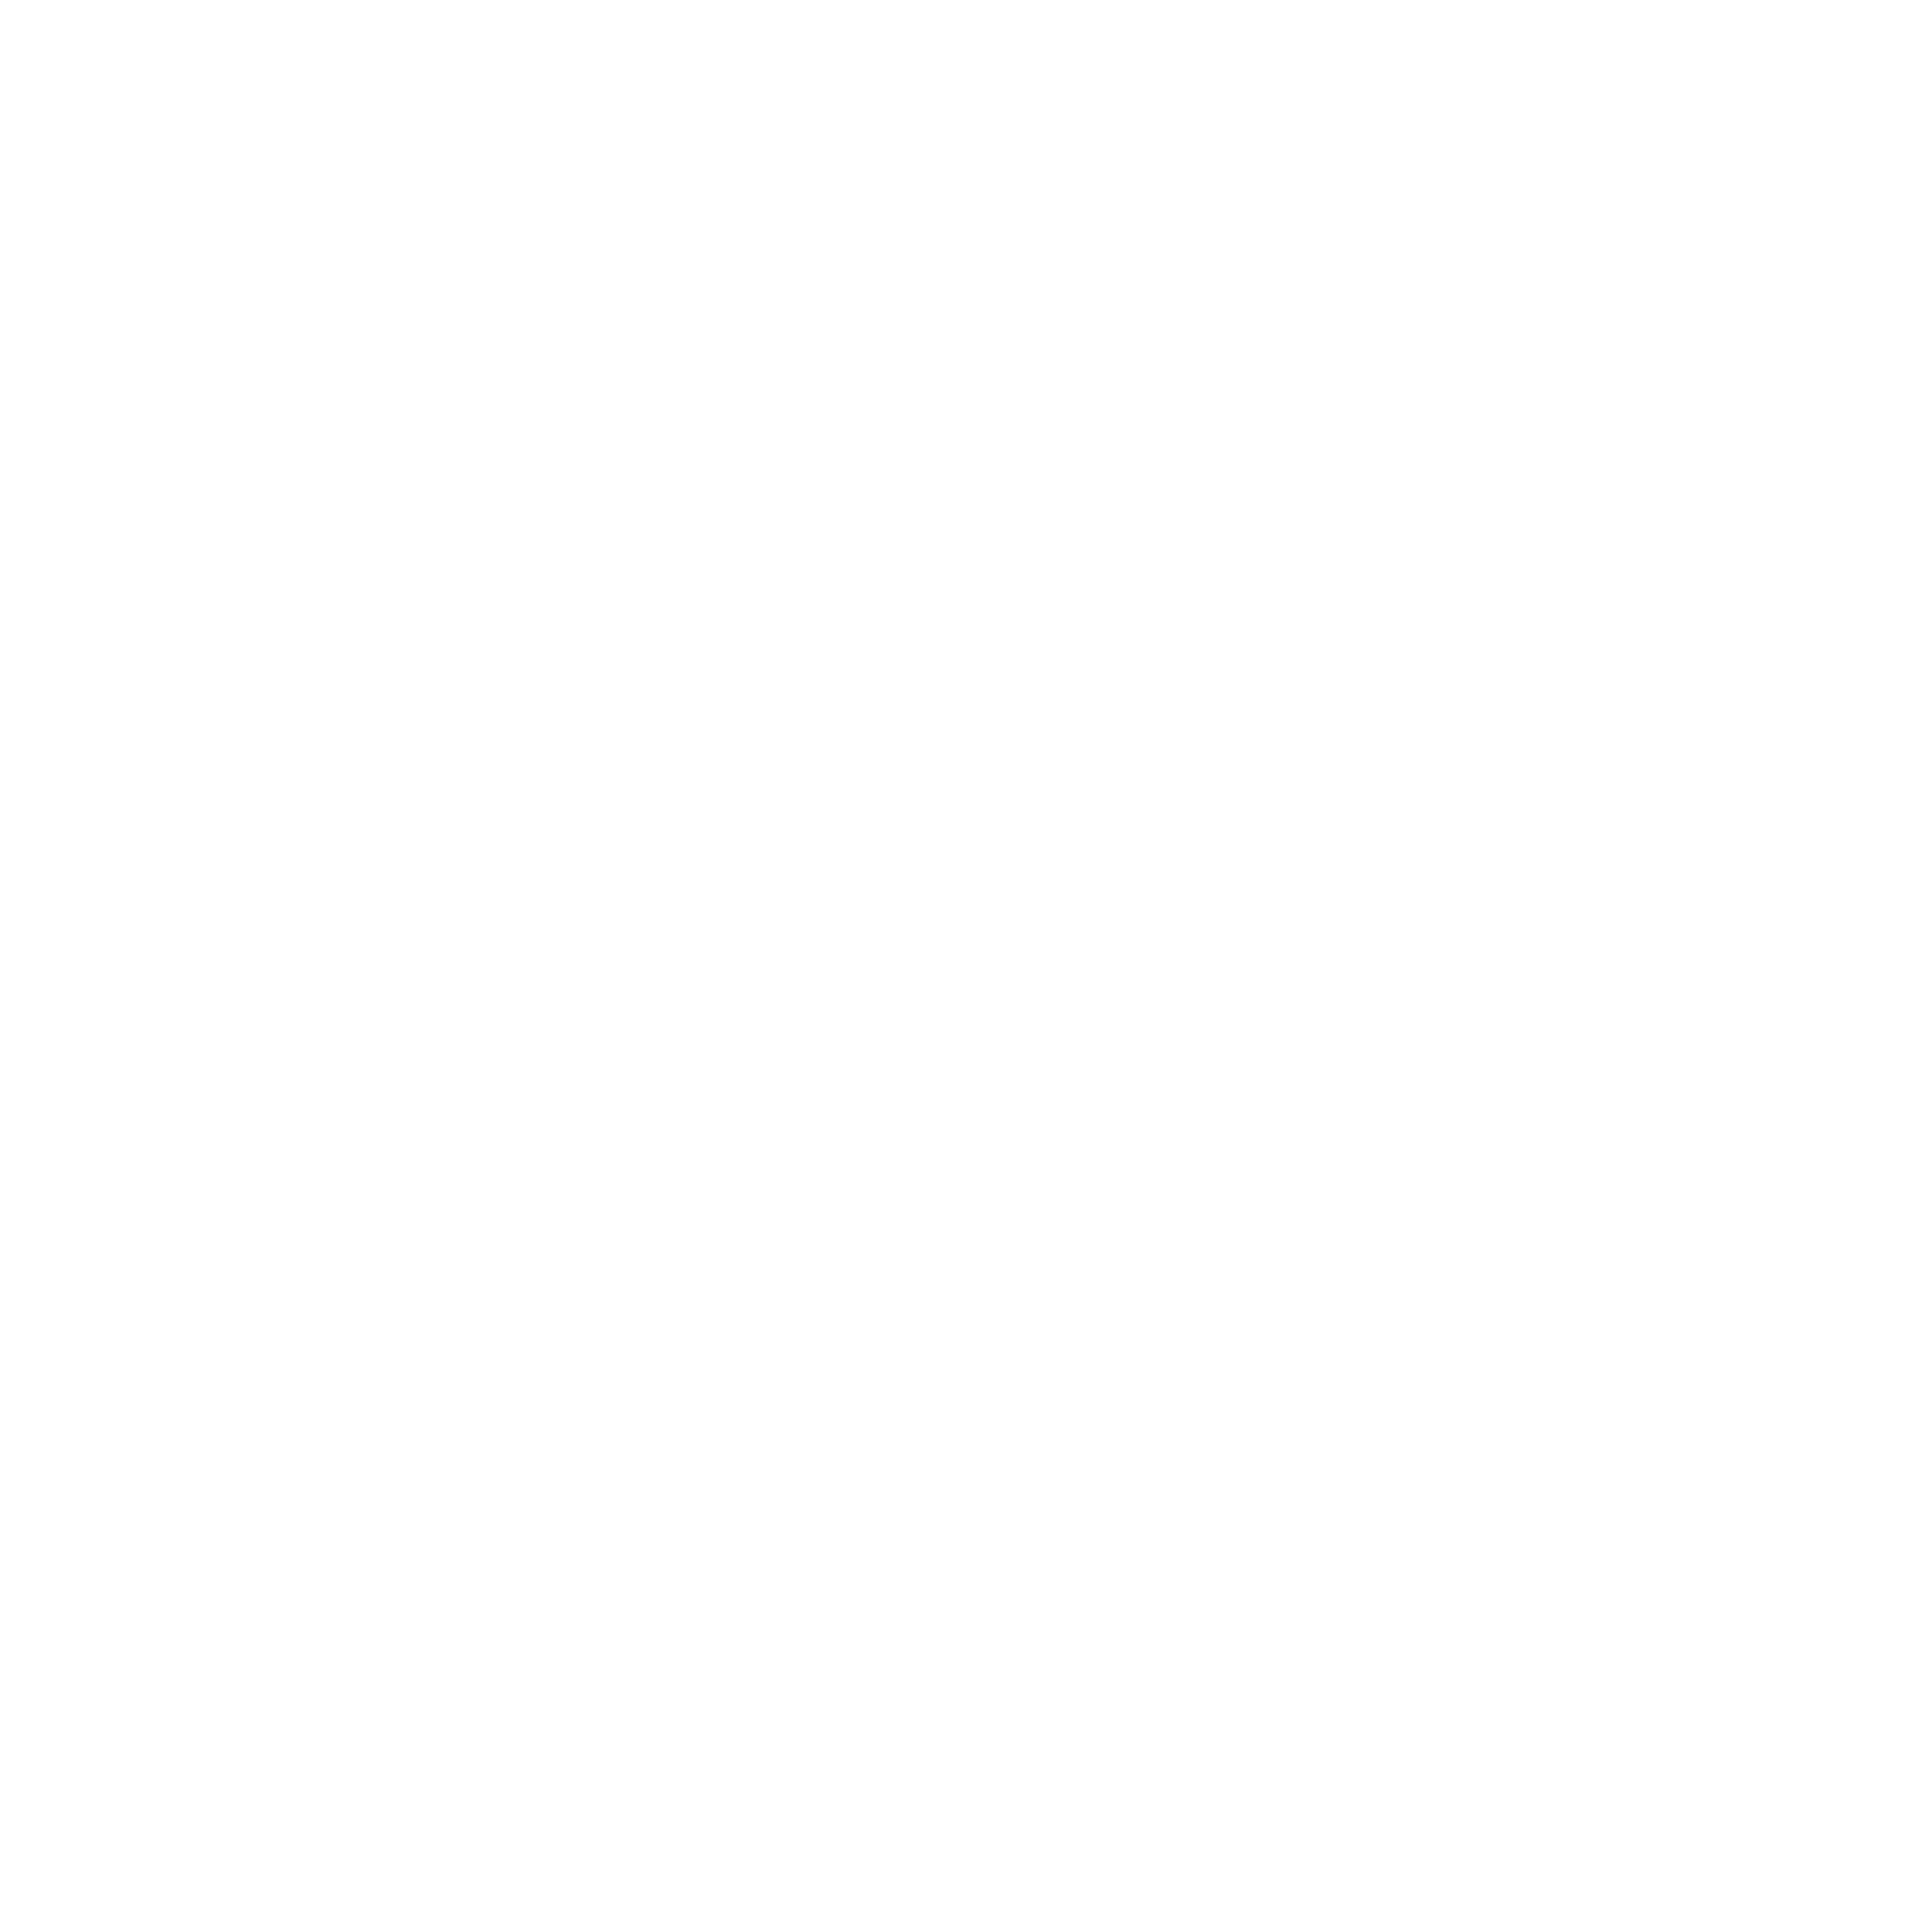

<IPython.core.display.Javascript object>


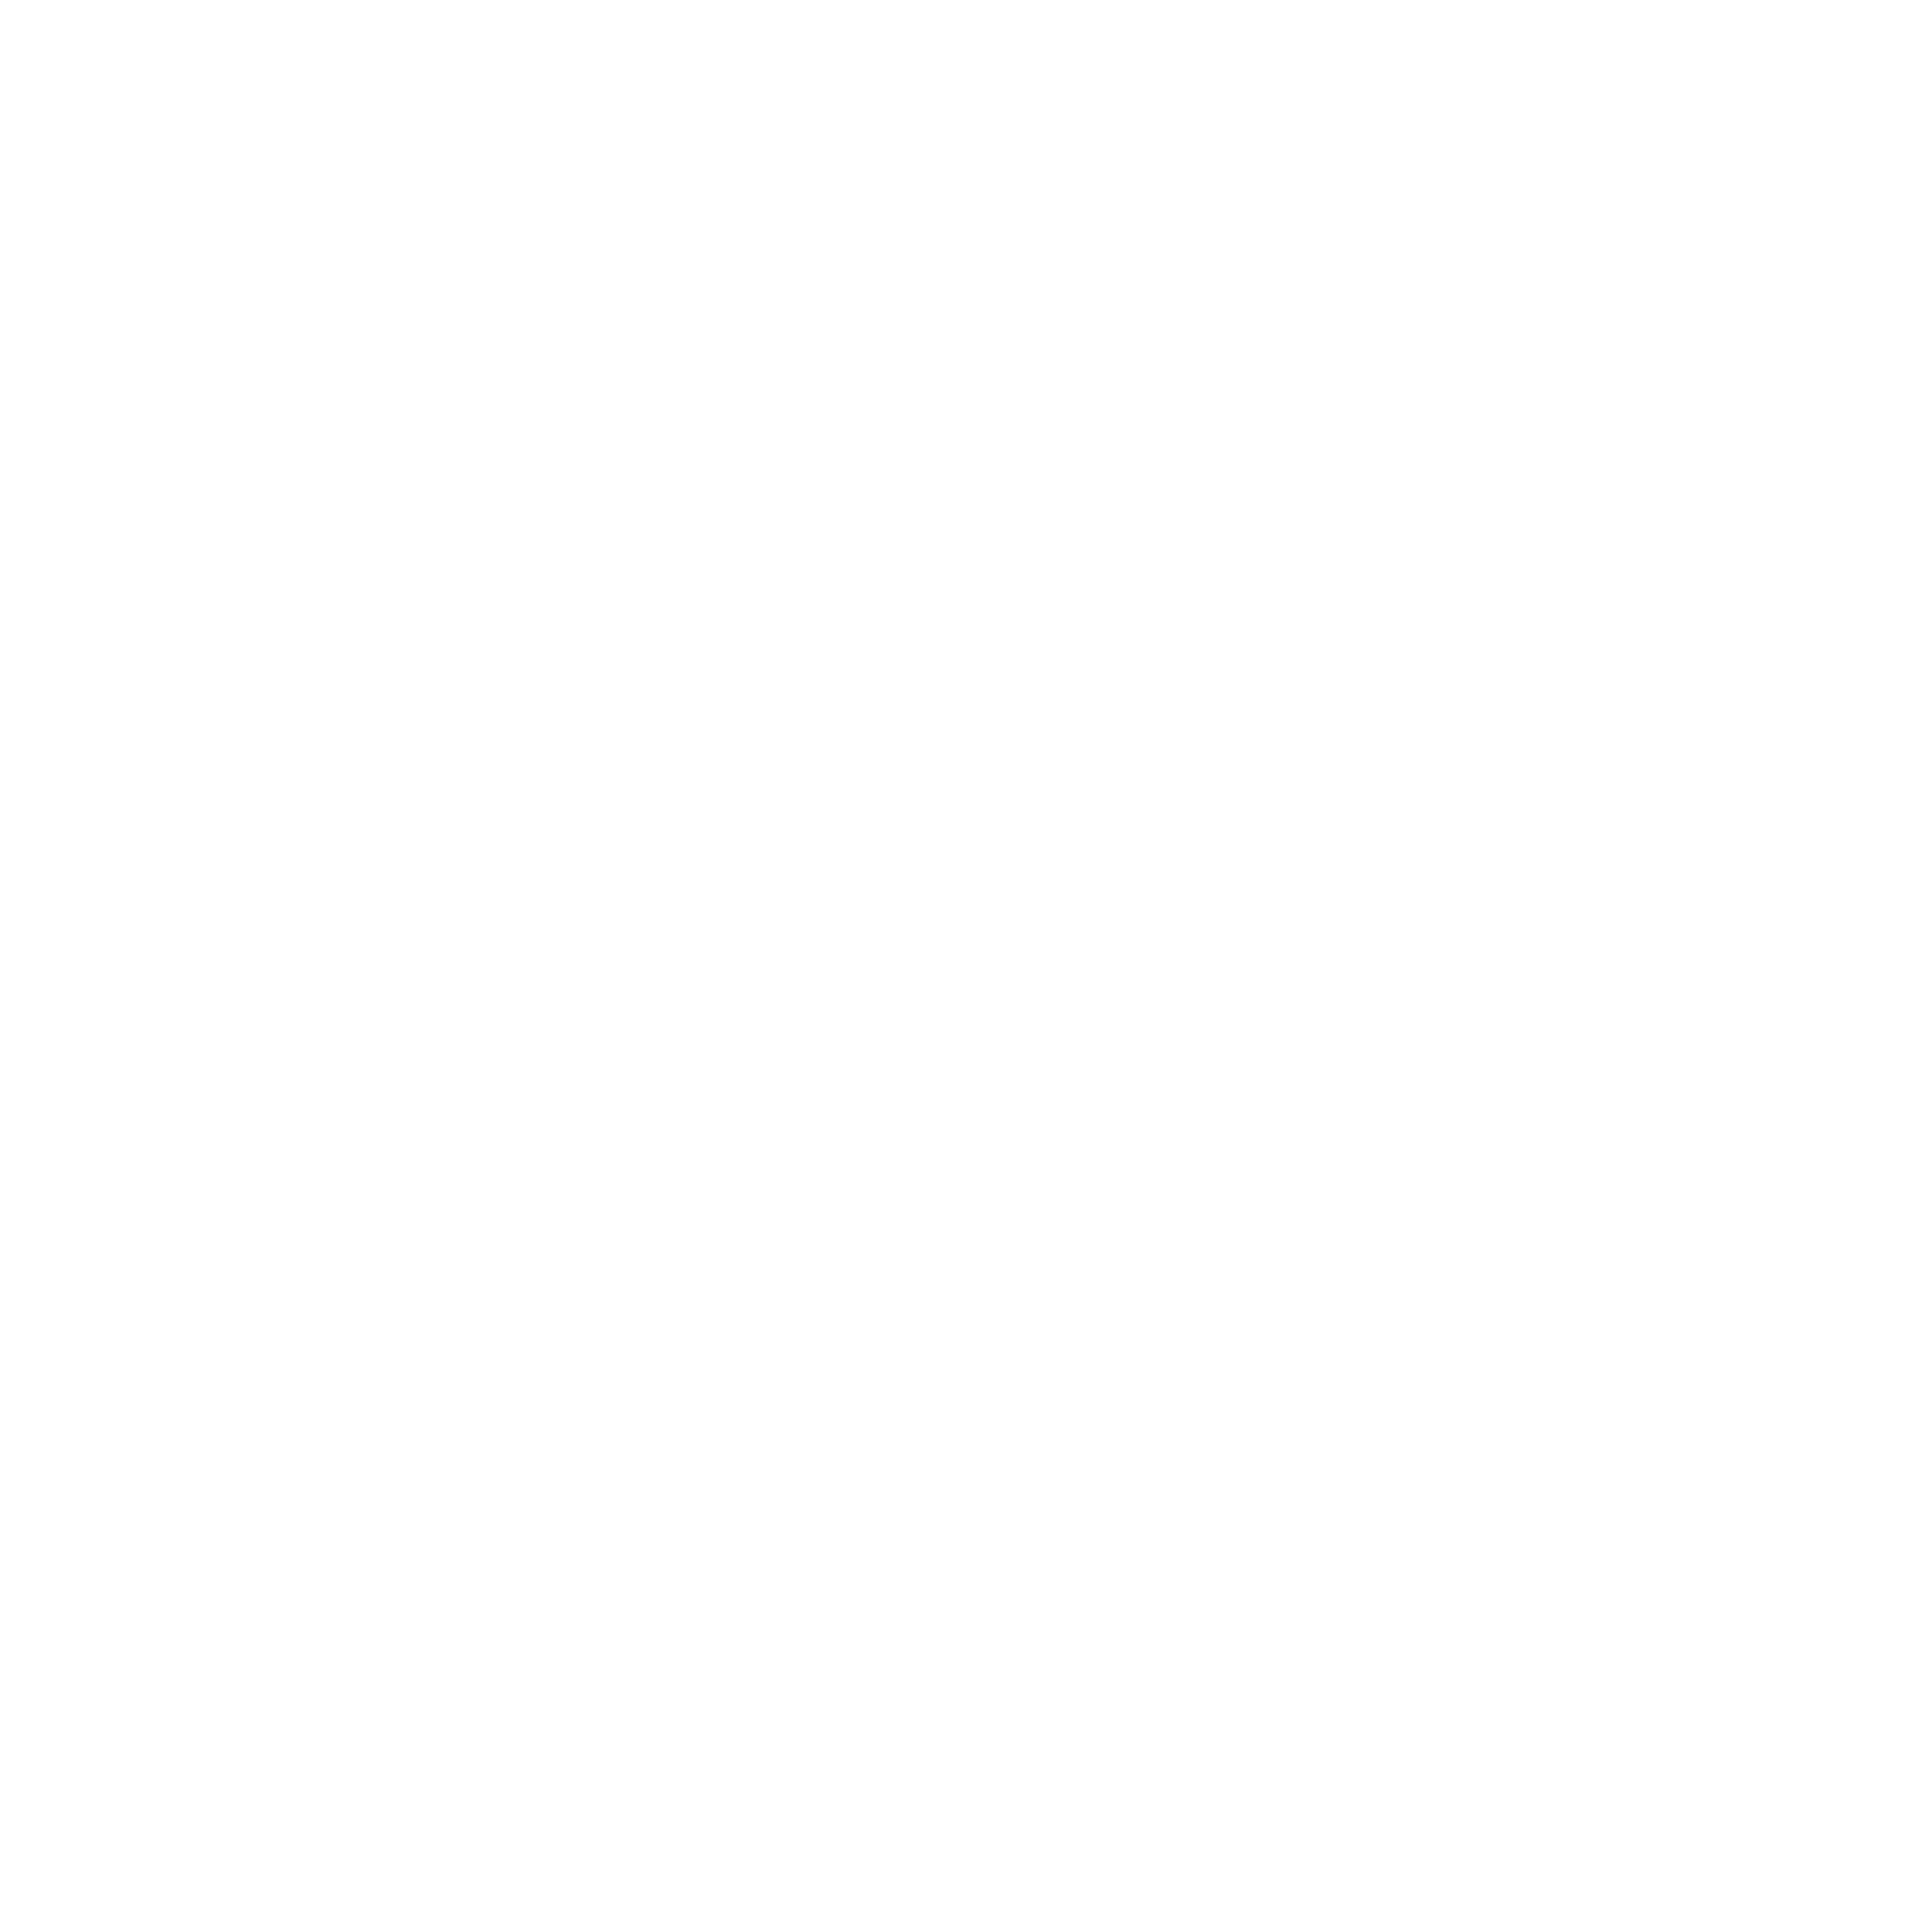

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [20]:
#Chafe Analysys
%matplotlib nbagg
if experiment == 2:
    q = int(mt.ceil(mt.sqrt(len(delays))))
    f1, ax1 = plt.subplots(figsize=(8, 8), nrows=int((len(delays)+1)/q), ncols=q, sharex=False)  
    f1.suptitle("" , fontweight='bold')

    f2, ax2 = plt.subplots(figsize=(8, 8), )

    fl = [item for sublist in list(Chafe.values()) for item in sublist] 

    for j in [0]:
        for i in range(len(delays)):
            for k in tempos:
                for trial in range(numrep):
                    dl = delays[i]
                    y = Chafe[(dl,k, trial)][2:]
                    x = range(len(y))
                    X_Y_Spline = make_interp_spline(x, y)
                    X_ = np.linspace(min(x), max(x), n*smoolth)
                    Y_ = X_Y_Spline(X_)
                    cl = list(clrs.keys())[i]
                    ax1[int(i/q), i%q].plot(X_, Y_, color=cl, alpha=0.4, label='str(dl)')
                    ax1[int(i/q), i%q].set_title('$\\tau_A$=$\\taux_B$='+str(dl)+'ms', fontname=fontface, fontsize="small")        
                    ax2.plot(X_, Y_, color=cl, alpha=0.4, label='str(dl)') # i/len(delays)
                    ax1[int(i/q), i%q].yaxis.set_major_locator(MaxNLocator(integer=True))
                    if 1: ax1[int(i/q), i%q].set_ylim ([min(fl),max(fl)])

    #plt.figtext(0.1, -0.0, marker1z+''.join(thislabel)  , size='small', fontname=fontface)
    mtb.rc('xtick', labelsize=8) 
    mtb.rc('ytick', labelsize=8)
    f1.tight_layout(w_pad=0.3, h_pad=0.1)

    f1.savefig(chartfolder+'/'+ exps[experiment-1] +'-' + str(agents[j])+'-Chafe(Figure 7).jpg', dpi=300)

In [ ]:
## Arealize

#jeojson parser:

In [ ]:
plt.plot()